In [1]:
import sys

# Add the directory containing fs.py to the Python path
sys.path.append('./modules')

# Assuming FuzzySystemLayer and create_fuzzy_model are defined in fs.py
from fs import FuzzySystemLayer, create_fuzzy_model


/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Paths to the prepped data files
base_path = './data/prepped_data/'  # Adjusted base path to where our files are now
X_train_path = base_path + 'X_train.csv'
X_test_path = base_path + 'X_test.csv'
y_train_path = base_path + 'y_train.csv'
y_test_path = base_path + 'y_test.csv'

# Loading the datasets
X_train = pd.read_csv(X_train_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

# Assuming the last columns of X_train and X_test are year, month, day, hour for reconstructing the datetime index
X_train['datetime'] = pd.to_datetime(X_train[['year', 'month', 'day', 'hour']])
X_test['datetime'] = pd.to_datetime(X_test[['year', 'month', 'day', 'hour']])
y_train.index = pd.to_datetime(X_train['datetime'])
y_test.index = pd.to_datetime(X_test['datetime'])

# Exclude non-numerical columns before scaling
columns_to_scale = X_train.columns.difference(['year', 'month', 'day', 'hour', 'datetime'])

# Initialize the scaler for the features
scaler_X = MinMaxScaler()

# Scale 'X' features (excluding non-numerical columns)
X_train_scaled = scaler_X.fit_transform(X_train[columns_to_scale])
X_test_scaled = scaler_X.transform(X_test[columns_to_scale])

# Initialize a separate scaler for the target variable
scaler_y = MinMaxScaler()

# Scale 'y' (the target variable)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


In [3]:
# Example: Using KMeans for finding cluster centers
from sklearn.cluster import KMeans

In [4]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
# Assuming FS_Regressor has been imported from the fs module


# Determine the optimal number of clusters (e.g., using domain knowledge, elbow method, etc.)
n_clusters = 3  # This is a placeholder; adjust based on our analysis

# Steps for cluster determination remain the same
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train_scaled)
cluster_centers = kmeans.cluster_centers_

# Define and train the TensorFlow-based model
model = create_fuzzy_model(input_dim=X_train_scaled.shape[1], cluster_centers=cluster_centers)
model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2)

# Predict and evaluate
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

# MSE, RMSE, and MAPE calculation
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
y_test_original = y_test.values.flatten()
mape_test = np.mean(np.abs((y_test_original - y_pred) / y_test_original)) * 100

print(f"Mean Squared Error (MSE) on Test Set: {mse_test}")
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")
print(f"Mean Absolute Percentage Error (MAPE) on Test Set: {mape_test}%")

Epoch 1/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step - loss: 0.0128 - val_loss: 0.0343
Epoch 2/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - loss: 0.0021 - val_loss: 0.0220
Epoch 3/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - loss: 0.0019 - val_loss: 0.0217
Epoch 4/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 0.0020 - val_loss: 0.0227
Epoch 5/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - loss: 0.0020 - val_loss: 0.0229
Epoch 6/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 0.0019 - val_loss: 0.0227
Epoch 7/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - loss: 0.0018 - val_loss: 0.0245
Epoch 8/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 0.0016 - val_loss: 0.0248
Epoch 9/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 0.0014 - val_loss: 0.0252
Epoch 10/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - loss: 0.0013 - val_loss: 0.0244
Epoch 11/100
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - loss: 0.0013 - val_loss: 0.02

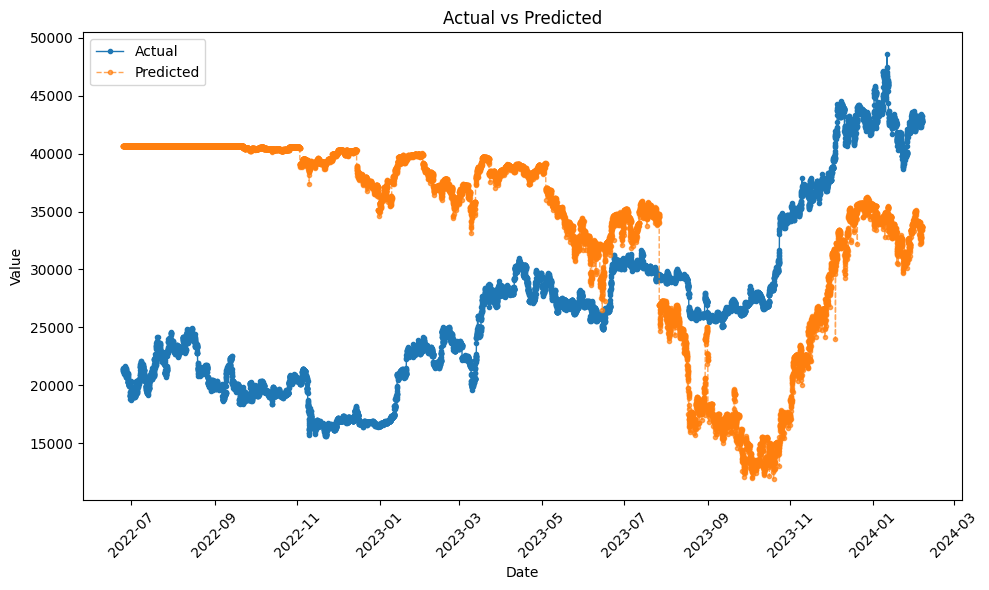

In [5]:
import matplotlib.pyplot as plt
y_test_original = y_test.values.flatten()[:len(y_pred)]  # Adjust length if necessary
# Assuming y_test_original and y_pred are correctly aligned with these dates
test_dates_aligned = X_test['datetime'].values[-len(y_pred):]

plt.figure(figsize=(10, 6))
plt.plot(test_dates_aligned, y_test_original, label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(test_dates_aligned, y_pred, label='Predicted', alpha=0.7, marker='.', linestyle='--', linewidth=1)
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Improve readability of the date labels
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
